# General E(2)-Equivariant Steerable CNNs  -  A concrete example


In [48]:
import os
import csv
import time
import random
from tqdm import tqdm

import numpy as np
from PIL import Image
import cv2

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
from torchsummary import summary

from e2cnn import gspaces
from e2cnn import nn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Finally, we build a **Steerable CNN** and try it MNIST.

Let's also use a group a bit larger: we now build a model equivariant to $8$ rotations.
We indicate the group of $N$ discrete rotations as $C_N$, i.e. the **cyclic group** of order $N$.
In this case, we will use $C_8$.

Because the inputs are still gray-scale images, the input type of the model is again a *scalar field*.

However, internally we use *regular fields*: this is equivalent to a *group-equivariant convolutional neural network*.

Finally, we build *invariant* features for the final classification task by pooling over the group using *Group Pooling*.

The final classification is performed by a two fully connected layers.

# The model

Here is the definition of our model:

In [2]:
class C8SteerableCNN(torch.nn.Module):
    
    def __init__(self, n_classes=10, cyclic_group=8):
        self.cyclic_group=cyclic_group
        
        super(C8SteerableCNN, self).__init__()
        
        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.Rot2dOnR2(N=self.cyclic_group)
        #print("self.r2_act", self.r2_act)
        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, 3*[self.r2_act.trivial_repr])
        #print("in_type", in_type)
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        #print("out_type", out_type)
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 80, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block1', self.block1.out_type.size)
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block2', self.block2.out_type.size)
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        print('pool1', self.pool1.out_type.size)
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block3', self.block3.out_type.size)
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block4', self.block4.out_type.size)
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        print('pool2', self.pool2.out_type.size)
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block5', self.block5.out_type.size)
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        print('block6', self.block6.out_type.size)
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        print('pool3', self.pool3.out_type.size)
        
        self.gpool = nn.GroupPooling(out_type) # pool3.out_type
        
        # number of output channels
        c = self.gpool.out_type.size
        print('gpool', c)
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c*13*13, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        #print("input.shape", input.shape)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        #print("x.shape1", x.shape)
        
        # pool over the group
        x = self.gpool(x)
        #print("x.shape2", x.shape)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        #print("x.shape3", x.shape)
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

In [3]:
# Not rotationally-equivariant architecture, mimics above as closely as possible
class NonRECNN(torch.nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        
        # convolution 1
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=24, kernel_size=7, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=24),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 2
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=48),
            torch.nn.ReLU(inplace=True)
        )
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        # convolution 3
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=48),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 4
        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(inplace=True)
        )
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        # convolution 5
        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=96, out_channels=96, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(inplace=True)
        )
        
        # convolution 6
        self.block6 = torch.nn.Sequential(
            # NOTE 1: changed padding=1 to padding=0 in this layer to help match input size of fc layer
            torch.nn.Conv2d(in_channels=96, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(inplace=True)
        )
        self.pool3 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
        # NOTE 2: added another avgpool2d to match input size of fc layer
        self.pool4 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
#        self.pool5 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)
#        self.pool6 = torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0)

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(64*13*13, 64),
            torch.nn.BatchNorm1d(num_features=64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        x = self.pool3(x)
        x = self.pool4(x)
#        x = self.pool5(x)
#        x = self.pool6(x)
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x

Let's build the model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cuda


In [194]:
EQUIVARIANT = True
n_classes = 15

if EQUIVARIANT:
    cyclic_group = 8
    model = C8SteerableCNN(n_classes=n_classes, cyclic_group=cyclic_group).to(device)
else:
    cyclic_group = 1
    model = NonRECNN(n_classes=n_classes).to(device)

summary(model, input_size=(3, 80, 80))

block1 192
block2 384
pool1 384
block3 384
block4 768
pool2 768
block5 768
block6 512
pool3 512
gpool 64
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        MaskModule-1            [-1, 3, 80, 80]               0
SingleBlockBasisExpansion-2             [-1, 8, 1, 49]               0
BlocksBasisExpansion-3                [-1, 3, 49]               0
            R2Conv-4          [-1, 192, 76, 76]               0
       BatchNorm3d-5        [-1, 24, 8, 76, 76]              48
    InnerBatchNorm-6          [-1, 192, 76, 76]               0
              ReLU-7          [-1, 192, 76, 76]               0
  SequentialModule-8          [-1, 192, 76, 76]               0
SingleBlockBasisExpansion-9             [-1, 8, 8, 25]               0
SingleBlockBasisExpansion-10             [-1, 8, 8, 25]               0
SingleBlockBasisExpansion-11             [-1, 8, 8, 25]               0
SingleBlockBasisExpansion-12  

In [195]:
# cyclic_group = 8
# n_classes = 15

# model1 = C8SteerableCNN(n_classes=n_classes, cyclic_group=cyclic_group).to(device)
# summary(model1, input_size=(3, 80, 80))

In [196]:
# model2 = NonRECNN(n_classes=n_classes).to(device)
# summary(model2, input_size=(3, 80, 80))

The model is now randomly initialized. 
Therefore, we do not expect it to produce the right class probabilities.

However, the model should still produce the same output for rotated versions of the same image.
This is true for rotations by multiples of $\frac{\pi}{2}$, but is only approximate for rotations by $\frac{\pi}{4}$.

Let's try the model on *rotated* MNIST

In [197]:
# # download the dataset
# !wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# # uncompress the zip file
# !unzip -n mnist_rotation_new.zip -d mnist_rotation_new

In [198]:
# import requests
# url = 'http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip'
# doc = requests.get(url)
# with open('mnistrot.zip', 'wb') as f:
#     f.write(doc.content)

Build the dataset

In [199]:
class DOTARotDataset(Dataset):
    
    def __init__(self, mode, transform=None, max_num_examples=0):
        assert mode in ['train', 'test']
        
        basedir = 'C:/Users/Admin/Desktop/data/DOTAv1.0/'
        
        if mode == "train":
            file = basedir+"chips_train/"
        else:
            file = basedir+"chips_val/"
        
        self.transform = transform
        self.max_num_examples = max_num_examples
        self.images = []
        self.labels = []
        new_image_width = 80
        new_image_height = 80
        color = (0,0,0)
        self.classdict = {}
        self.classval = 0

        #data = np.loadtxt(file, delimiter=' ')
        data = []
        
        for root, dirs, filenames in os.walk(file, topdown=False):
            pass
        for d in dirs:
            for root, dirs, filenames in os.walk(file+d, topdown=False):
                pass
            #print(d, len(filenames))
            for f in filenames:
                imgstr = file+d+"/"+f
                #img = Image.open(imgstr)
                #arr = np.asarray(img)
                img = cv2.imread(imgstr)
                old_image_height, old_image_width, channels = img.shape
                #print('old', old_image_height, old_image_width)
                if img.shape[0] < img.shape[1]:
                    result1 = np.full((img.shape[1],img.shape[1], channels), color, dtype=np.uint8)
                    #print('shape', result1.shape)
                    # compute center offset
                    #x_center = np.abs(new_image_width - old_image_width) // 2
                    y_center = np.abs(img.shape[1] - old_image_height) // 2
                    #print('y_center', y_center)
                    # copy img image into center of result image
                    result1[y_center:y_center+old_image_height, :] = img
                elif img.shape[0] > img.shape[1]:
                    result1 = np.full((img.shape[0],img.shape[0], channels), color, dtype=np.uint8)
                    #print('shape', result1.shape)
                    # compute center offset
                    x_center = np.abs(img.shape[0] - old_image_width) // 2
                    #y_center = np.abs(new_image_height - old_image_height) // 2
                    #print('x_center', x_center)
                    # copy img image into center of result image
                    result1[:, x_center:x_center+old_image_width] = img
                else:
                    result1 = img[:,:,:]
                # check if we need to resize
                if not (result1.shape[0] == 80 and result1.shape[1] == 80):
                    #print('result1.shape1', result1.shape)
                    result1 = cv2.resize(result1, dsize=(80, 80), interpolation=cv2.INTER_CUBIC)
                    #print('result1.shape2', result1.shape)
                res2 = result1.reshape(-1, 80, 80).astype(np.float32) # = arr[:, :-1].reshape(-1, 80, 80)
                #print('res2.shape', res2.shape)
                
                # ToTensor screws up the order, so we have to undo it:
                # https://discuss.pytorch.org/t/torchvision-totensor-dont-change-channel-order/82038/2
                #res2 = res2.permute((1, 2, 0)).contiguous()
                
                # convert back to PIL Image object for pytorch transforms (e.g. RandomRotation) to work
                #image = Image.fromarray(image)
                
                self.images.append(res2)
        
                # labels
                if self.classdict.get(d, -1) >= 0:
                    self.labels.append(self.classdict[d])
                else: # it's not in self.classdict yet
                    self.classdict[d] = self.classval
                    self.classval += 1
        
        if self.max_num_examples > 0:
            #z1 = list(zip(self.images, self.labels))
            classdict = {}
            for i in range(len(self.labels)):
                if classdict.get(self.labels[i], False):
                    classdict[self.labels[i]].append(self.images[i])
                else:
                    classdict[self.labels[i]] = [self.images[i]]
            self.images = []
            self.labels = []
            for i in range(self.classval):
                ####################################################
                # if too many examples, take self.max_num_examples random examples for that class
                ####################################################
                if len(classdict[i]) > self.max_num_examples:
                    temp = random.sample(classdict[i], self.max_num_examples)

                    for t in temp:
                        self.images.append(t)
                        self.labels.append(i)
                ####################################################
                # if not enough examples, take all examples of that class
                ####################################################
                else:
                    for t in classdict[i]:
                        self.images.append(t)
                        self.labels.append(i)

        self.num_samples = len(self.labels)
        print("self.num_samples", self.num_samples)
    
    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        # image is a numpy ndarray instead of PIL Image object
        # NOTE: certain pytorch functions (aka RandomRotate) require PIL Image objects
        # ToTensor screws up the shape/channel order, so we have to undo it:
        # https://discuss.pytorch.org/t/torchvision-totensor-dont-change-channel-order/82038/2
        #image = image.permute((1, 2, 0)).contiguous()
        #image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

# images are padded to have shape 29x29.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
#pad = Pad((0, 0, 1, 1), fill=0)

# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
#resize1 = Resize(80*3)
#resize2 = Resize(80)

#totensor = ToTensor()

In [200]:
# build the test set
#raw_mnist_test = DOTARotDataset(mode='test')

In [201]:
# retrieve the first image from the test set
#x, y = next(iter(raw_mnist_test))
#
#print(x.shape)
#print(raw_mnist_test[3530])

In [202]:
def test_model(model: torch.nn.Module, x: Image):
    # evaluate the `model` on 8 rotated versions of the input image `x`
    model.eval()
    totensor = ToTensor()
    
    wrmup = model(torch.randn(1, 3, 80, 80).to(device))
    del wrmup
    
    #x = resize1(pad(x))
    
    print()
    print('##########################################################################################')
    header = 'angle |  ' + '  '.join(["{:6d}".format(d) for d in range(15)])
    print(header)
    with torch.no_grad():
        for r in range(8):
            #print(np.min(x), np.max(x), x.shape)
            intimg = x.astype(np.uint8)
            #print(type(intimg))
            #print(np.min(intimg), np.max(intimg), intimg.shape)
            # go from 3,80,80 -> 80,80,3
            #intimg2 = intimg.permute((1, 2, 0)).contiguous() # can't permute numpy arrays
            intimg2 = intimg.transpose(1, 2, 0)
            #print(np.min(intimg2), np.max(intimg2), intimg2.shape)
            img = Image.fromarray(intimg2)
            #print(np.min(img), np.max(img))
            rotimg = img.rotate(r*45., Image.BILINEAR)
            #print(rotimg.shape)
            x_transformed = totensor(rotimg).reshape(-1, 3, 80, 80)
            x_transformed = x_transformed.to(device)

            y = model(x_transformed)
            y = y.to('cpu').numpy().squeeze()
            
            angle = r * 45
            print("{:3d}:{}".format(angle, y))
    print('##########################################################################################')
    print()

In [203]:
# evaluate the model
#test_model(model, x)

The output of the model is already almost invariant.
However, we still observe small fluctuations in the outputs.

This is because the model contains some operations which might break equivariance.
For instance, every convolution includes a padding of $2$ pixels per side. This is adds information about the actual orientation of the grid where the image/feature map is sampled because the padding is not rotated with the image. 

During training, the model will observe rotated patterns and will learn to ignore the noise coming from the padding.

So, let's train the model now.
The model is exactly the same used to train a normal *PyTorch* architecture:

In [204]:
# Prep the training dataset
train_transform = Compose([
    #pad,
    #resize1,
    #RandomRotation(180, resample=Image.BILINEAR, expand=False),
    #resize2,
    #ToTensor()
])

#data_train = DOTARotDataset(mode='train', transform=train_transform)
#train_loader = torch.utils.data.DataLoader(data_train, batch_size=8, shuffle=True)
#print(len(data_train), len(train_loader))

In [205]:
def get_fresh_training_data(n):
    data_train = DOTARotDataset(mode='train', transform=train_transform, max_num_examples=n)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=8, shuffle=True, drop_last=True)
    #print(len(data_train), len(train_loader))
    return train_loader

In [206]:
# Prep the testing dataset
test_transform = Compose([
    #pad,
    #ToTensor()
])

data_test = DOTARotDataset(mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=8, shuffle=False, drop_last=True)
print(len(data_test), len(test_loader))

self.num_samples 28838
28838 3604


In [207]:
# mini = 99999
# maxi = 0
# for m in data_train: # data_test
#     if m[1] < mini:
#         mini = m[1]
#     if m[1] > maxi:
#         maxi = m[1]
# print(mini, maxi, "<--- should be 0 14 instead of 1 15")

In [208]:
def save_the_model(model, cyclic_group, epoch, train_acc, train_loss, test_acc, test_loss):
    if not os.path.exists("models"):
        os.mkdir("models")
    model_name = "models/model_dota_C"+str(cyclic_group)+"_"+str(epoch)+"_"+str(round(train_acc,4))+"_"+str(round(train_loss,4))+"_"+str(round(test_acc,4))+"_"+str(round(test_loss,4))+".pth"
#    if not os.path.exists("models/model_dota.pth"):
    torch.save(model.state_dict(), model_name)
#    print('saved')
#    else:
#         model.load_state_dict(torch.load("models/model_dota.pth"))
#         print('loaded')

In [209]:
def save_the_results(cyclic_group, epoch, train_accuracy, train_loss, test_accuracy, test_loss):
    add_headers = False
    if not os.path.exists("results"):
        os.mkdir("results")
    if not os.path.exists("results/model_dota.csv"):
        add_headers = True
    # writing to csv file
    with open("results/model_dota.csv", 'a', newline='') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)

        if add_headers:
            csvwriter.writerow(['Cyclic Group', 'Epoch', 'Train Accuracy', 'Train Loss', 'Test Accuracy', 'Test Loss'])

        # writing the data rows
        csvwriter.writerow([cyclic_group, epoch, train_accuracy, train_loss, test_accuracy, test_loss])

In [211]:
# Initialize the model
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

######################################################
# IF CONTINUING TRAINING, LOAD MODEL FROM LAST EPOCH
######################################################

# train_loader = get_fresh_training_data(30000)
if EQUIVARIANT:
    model.load_state_dict(torch.load("models/model_dota_C8_65_97.6337_874.7356_84.8987_2469.3884.pth"))
else:
    model.load_state_dict(torch.load("models/model_dota_C1_64_95.0866_865.1543_86.0953_1910.6196.pth"))

In [212]:
# # get initial performance with random weights
# test_total = 0
# test_correct = 0
# test_loss = 0
# with torch.no_grad():
#     model.eval()
    
#     #for i, (x, t) in enumerate(test_loader):
#     with tqdm(test_loader, unit="batch") as tepoch:
#         for x, t in tepoch:
#             tepoch.set_description(f"Epoch {-1}")
            
#             #if i%1000==0:
#             #    print(i, "/", len(test_loader))

#             x = x.to(device)
#             t = t.to(device)

#             y = model(x)

#             _, prediction = torch.max(y.data, 1)
#             if prediction.shape[0] != t.shape[0]:
#                 print(t)
#                 t = t[:-(t.shape[0]-prediction.shape[0])]
#                 print(t)
#             test_total += t.shape[0]
#             test_correct += (prediction == t).sum().item()

#             loss = loss_function(y, t)
#             test_loss += loss

# test_accuracy = test_correct/test_total*100.
    
# print(f"test accuracy: {test_accuracy}")
# print(f"test loss: {test_loss.item()}")

In [213]:
# samples_per_class = 500
# increase_by = 100
# start_epoch = 0
# max_epochs = 100

# for epoch in range(start_epoch, max_epochs):
    
#     print('starting epoch', epoch)
    
#     ########################################
#     # TRAIN
#     ########################################
#     train_total = 0
#     train_correct = 0
#     train_loss = 0
#     model.train()
    
#     # NOTE: i pull fresh training data examples each epoch to counter the huge class imbalance.
#     #       i keep the validation data the same each epoch though to make sure i'm consistently
#     #       measuring validation accuracy/loss.
#     train_loader = get_fresh_training_data(samples_per_class)
#     print("samples_per_class", samples_per_class)
#     # NOTE: increasing the number of samples per class will mess up the loss curve because i am
#     #       adding more examples and thus more potential loss each epoch. comment the next line out
#     #       if you wish to avoid this.
#     samples_per_class += increase_by
    
#     #for i, (x, t) in enumerate(train_loader):
#     with tqdm(train_loader, unit="batch") as tepoch:
#         for x, t in tepoch:
#             tepoch.set_description(f"Epoch {epoch}")

#             #if i%5000==0:
#             #    print(i, "/", len(train_loader))

#             optimizer.zero_grad()

#             x = x.to(device)
#             t = t.to(device)

#             y = model(x)

#             _, prediction = torch.max(y.data, 1)
#             # sometimes at the end of an epoch, prediction.shape can be < t.shape
#             if prediction.shape[0] != t.shape[0]:
#                 #print(t)
#                 t = t[:-(t.shape[0]-prediction.shape[0])]
#                 #print(t)
#             train_total += t.shape[0]
#             train_correct += (prediction == t).sum().item()

#             loss = loss_function(y, t)
#             train_loss += loss

#             loss.backward()

#             optimizer.step()
#     tepoch.close()

#     ########################################
#     # TEST
#     ########################################
#     test_total = 0
#     test_correct = 0
#     test_loss = 0
    
#     with torch.no_grad():
#         model.eval()
        
#         #for i, (x, t) in enumerate(test_loader):
#         with tqdm(test_loader, unit="batch") as tepoch:
#             for x, t in tepoch:
#                 tepoch.set_description(f"Epoch {epoch}")
                
#                 #if i%5000==0:
#                 #    print(i, "/", len(test_loader))

#                 x = x.to(device)
#                 t = t.to(device)

#                 y = model(x)

#                 _, prediction = torch.max(y.data, 1)
#                 if prediction.shape[0] != t.shape[0]:
#                     #print(t)
#                     t = t[:-(t.shape[0]-prediction.shape[0])]
#                     #print(t)
#                 test_total += t.shape[0]
#                 test_correct += (prediction == t).sum().item()

#                 loss = loss_function(y, t)
#                 test_loss += loss

#     train_accuracy = train_correct/train_total*100.
#     test_accuracy = test_correct/test_total*100.

#     #print(f"epoch {epoch} | train accuracy: {train_accuracy}")
#     #print(f"epoch {epoch} | train loss: {train_loss.item()}")
#     #print(f"epoch {epoch} | test accuracy: {test_accuracy}")
#     #print(f"epoch {epoch} | test loss: {test_loss.item()}")

#     tepoch.set_postfix({"train_accuracy":train_accuracy, 
#                         "train_loss":train_loss.item(),
#                         "test_accuracy":test_accuracy,
#                         "test_loss":test_loss.item()})
#     tepoch.close()
#     time.sleep(0.5)
    
#     save_the_results(cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())
#     save_the_model(model, cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())

In [214]:
# train_accuracy = train_correct/train_total*100.
# print(train_correct, train_total, train_accuracy)
#save_the_results(cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())
#save_the_model(model, cyclic_group, epoch, train_accuracy, train_loss.item(), test_accuracy, test_loss.item())

In [215]:
# print(prediction.shape, t.shape)
# print(prediction)
# print(t)
# print(t[:-1])
# print(y.shape)
# print(torch.max(y.data, 1)) # 1 is the dimension

In [216]:
# epoch -1 | test accuracy: 10.011096469935502
# epoch -1 | test loss: 2109988.5

# epoch 0 | train accuracy: 52.91684784257414
# epoch 0 | train loss: 42925.43359375
# epoch 0 | test accuracy: 18.846660656078782
# epoch 0 | test loss: 201328.765625

In [217]:
#data_test = DOTARotDataset(mode='test')

In [218]:
# retrieve the first image from the test set
x, y = next(iter(data_test))

# evaluate the model
test_model(model, x)


##########################################################################################
angle |       0       1       2       3       4       5       6       7       8       9      10      11      12      13      14
  0:[ -5.4399  -5.4694   4.0595  -4.9289   0.7132 -13.8629  -0.669  -14.9459  -4.6336   1.035    1.5407  -6.7582  -5.4432 -12.7076  -2.2076]
 45:[ -5.4158  -5.4492   4.0416  -4.9174   0.7099 -13.8612  -0.6723 -14.9522  -4.6271   1.0464   1.5253  -6.7561  -5.4346 -12.6937  -2.196 ]
 90:[ -5.4324  -5.4505   4.0584  -4.9172   0.7106 -13.8549  -0.6593 -14.9337  -4.6445   1.0431   1.5228  -6.7406  -5.4371 -12.7039  -2.2052]
135:[ -5.43    -5.4618   4.0581  -4.9191   0.7285 -13.8678  -0.6318 -14.9235  -4.6337   1.0234   1.5141  -6.7341  -5.4235 -12.7066  -2.21  ]
180:[ -5.4444  -5.4767   4.0709  -4.9222   0.7275 -13.8817  -0.6243 -14.9245  -4.6317   1.0095   1.5259  -6.7431  -5.4235 -12.718   -2.2274]
225:[ -5.4365  -5.4824   4.067   -4.937    0.7361 -13.877   -0.6457 -14.919

In [219]:
n_classes = 15

confusion_matrix = torch.zeros(n_classes, n_classes)
with torch.no_grad():
#     for i, (x, t) in enumerate(test_loader):
#         if i%1000==0:
#             print(i, "/", len(test_loader))
    with tqdm(test_loader, unit="batch") as tepoch:
        for x, t in tepoch:
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            _, preds = torch.max(y, 1)
            for t2, p in zip(t.view(-1), preds.view(-1)):
                confusion_matrix[t2.long(), p.long()] += 1

100%|██████████| 3604/3604 [04:03<00:00, 14.79batch/s]


In [220]:
print(confusion_matrix)

tensor([[1.3600e+02, 0.0000e+00, 3.0000e+00, 2.0000e+00, 9.0000e+00, 0.0000e+00,
         3.0000e+00, 3.0000e+00, 1.1000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         3.7000e+01, 5.0000e+00, 1.0000e+00],
        [4.0000e+00, 7.7000e+01, 1.1000e+01, 3.0000e+00, 4.0000e+00, 0.0000e+00,
         2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+01, 1.0000e+00, 7.0000e+00,
         1.0000e+00, 0.0000e+00, 8.0000e+00],
        [6.0000e+00, 4.0000e+00, 3.2200e+02, 2.0000e+00, 3.0000e+01, 1.0000e+00,
         1.9000e+01, 9.0000e+00, 3.0000e+00, 4.9000e+01, 6.0000e+00, 3.0000e+00,
         7.0000e+00, 0.0000e+00, 2.0000e+00],
        [1.0000e+00, 9.0000e+00, 2.1000e+01, 3.7000e+01, 1.2000e+01, 0.0000e+00,
         4.0000e+00, 3.0000e+00, 1.0000e+00, 2.6000e+01, 2.0000e+00, 1.0000e+01,
         5.0000e+00, 4.0000e+00, 8.0000e+00],
        [0.0000e+00, 1.0000e+00, 3.6000e+01, 4.0000e+00, 1.5410e+03, 1.0000e+00,
         1.6200e+02, 3.4000e+01, 6.0000e+00, 1.7300e+02, 1.0400e+02, 2.0000e+00,
      

In [221]:
cm = confusion_matrix.numpy().copy()
cm = cm.astype('int32')
print(cm)

[[ 136    0    3    2    9    0    3    3   11    3    0    0   37    5    1]
 [   4   77   11    3    4    0    2    2    1   10    1    7    1    0    8]
 [   6    4  322    2   30    1   19    9    3   49    6    3    7    0    2]
 [   1    9   21   37   12    0    4    3    1   26    2   10    5    4    8]
 [   0    1   36    4 1541    1  162   34    6  173  104    2    5   16    4]
 [   0    0    0    0   10   20    2   25    1   10    0    0    1    1    2]
 [   1    0   16    0   53    4 3601   17    0  414  265    0    4   11    0]
 [   0    1   10    0   22    4   17 2337    0   88   14    0   34    3    0]
 [  16    0   15    0    1    1    1   18   70    6    5    1   44    0    0]
 [   6    3  117   10  231    1  404   30    9 7893  217    3   18   14    3]
 [   1    0   14    0   26    0  231   14    2  328 4809    0    1   11    0]
 [   1    5   18    7   10    1    4    1    0   12   12   57   10    1   13]
 [   7    0   25    0   19    1   13   25   18   29   33    7 26

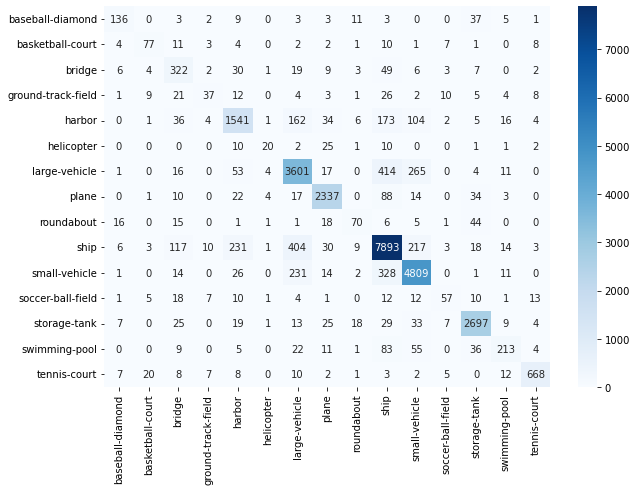

In [222]:
if EQUIVARIANT:
    cnum = "8"
else:
    cnum = "1"

dfcm = pd.DataFrame(cm,
                    index = ['baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor', 
                             'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
                             'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'],
                    columns=['baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor', 
                             'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
                             'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'])
plt.figure(figsize = (10,7))
sns.heatmap(dfcm, annot=True, cmap="Blues", fmt='d')
plt.savefig("results/c"+cnum+"_confusion_matrix_dota_counts.png",
            dpi=100,
            bbox_inches='tight')

In [223]:
print(100*confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([63.8498, 58.7786, 69.5464, 25.8741, 73.7673, 27.7778, 82.1021, 92.3715,
        39.3258, 88.1013, 88.4495, 37.5000, 93.4188, 48.5194, 88.7118])


In [224]:
cm2 = confusion_matrix.numpy().copy()
print(cm2)

[[1.360e+02 0.000e+00 3.000e+00 2.000e+00 9.000e+00 0.000e+00 3.000e+00 3.000e+00 1.100e+01 3.000e+00 0.000e+00 0.000e+00 3.700e+01 5.000e+00 1.000e+00]
 [4.000e+00 7.700e+01 1.100e+01 3.000e+00 4.000e+00 0.000e+00 2.000e+00 2.000e+00 1.000e+00 1.000e+01 1.000e+00 7.000e+00 1.000e+00 0.000e+00 8.000e+00]
 [6.000e+00 4.000e+00 3.220e+02 2.000e+00 3.000e+01 1.000e+00 1.900e+01 9.000e+00 3.000e+00 4.900e+01 6.000e+00 3.000e+00 7.000e+00 0.000e+00 2.000e+00]
 [1.000e+00 9.000e+00 2.100e+01 3.700e+01 1.200e+01 0.000e+00 4.000e+00 3.000e+00 1.000e+00 2.600e+01 2.000e+00 1.000e+01 5.000e+00 4.000e+00 8.000e+00]
 [0.000e+00 1.000e+00 3.600e+01 4.000e+00 1.541e+03 1.000e+00 1.620e+02 3.400e+01 6.000e+00 1.730e+02 1.040e+02 2.000e+00 5.000e+00 1.600e+01 4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01 2.000e+01 2.000e+00 2.500e+01 1.000e+00 1.000e+01 0.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00]
 [1.000e+00 0.000e+00 1.600e+01 0.000e+00 5.300e+01 4.000e+00 3.601e+03 1.700e+01 

In [225]:
print(confusion_matrix.sum(1))

tensor([ 213.,  131.,  463.,  143., 2089.,   72., 4386., 2530.,  178., 8959.,
        5437.,  152., 2887.,  439.,  753.])


In [226]:
for row in range(len(cm2)):
    for col in range(len(cm2[row])):
        cm2[row, col] = (100 * cm2[row, col]) / (confusion_matrix.sum(1)[row])

In [227]:
cm2 = cm2.astype('float32')
print(cm2)

[[6.3850e+01 0.0000e+00 1.4085e+00 9.3897e-01 4.2254e+00 0.0000e+00 1.4085e+00 1.4085e+00 5.1643e+00 1.4085e+00 0.0000e+00 0.0000e+00 1.7371e+01 2.3474e+00 4.6948e-01]
 [3.0534e+00 5.8779e+01 8.3969e+00 2.2901e+00 3.0534e+00 0.0000e+00 1.5267e+00 1.5267e+00 7.6336e-01 7.6336e+00 7.6336e-01 5.3435e+00 7.6336e-01 0.0000e+00 6.1069e+00]
 [1.2959e+00 8.6393e-01 6.9546e+01 4.3197e-01 6.4795e+00 2.1598e-01 4.1037e+00 1.9438e+00 6.4795e-01 1.0583e+01 1.2959e+00 6.4795e-01 1.5119e+00 0.0000e+00 4.3197e-01]
 [6.9930e-01 6.2937e+00 1.4685e+01 2.5874e+01 8.3916e+00 0.0000e+00 2.7972e+00 2.0979e+00 6.9930e-01 1.8182e+01 1.3986e+00 6.9930e+00 3.4965e+00 2.7972e+00 5.5944e+00]
 [0.0000e+00 4.7870e-02 1.7233e+00 1.9148e-01 7.3767e+01 4.7870e-02 7.7549e+00 1.6276e+00 2.8722e-01 8.2815e+00 4.9785e+00 9.5740e-02 2.3935e-01 7.6592e-01 1.9148e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.3889e+01 2.7778e+01 2.7778e+00 3.4722e+01 1.3889e+00 1.3889e+01 0.0000e+00 0.0000e+00 1.3889e+00 1.3889e+00 2.77

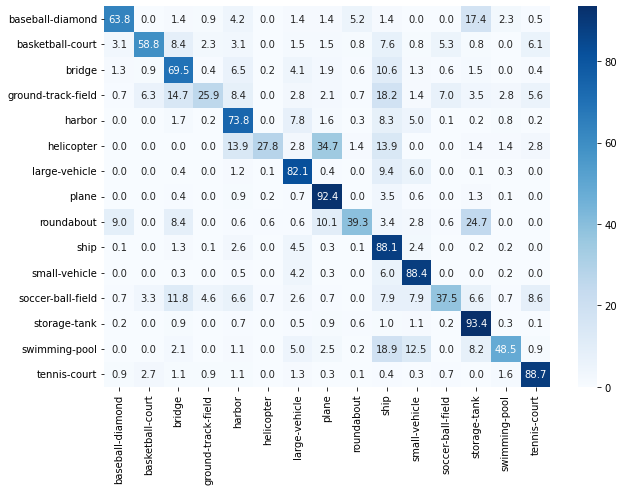

In [228]:
if EQUIVARIANT:
    cnum = "8"
else:
    cnum = "1"

dfcm2 = pd.DataFrame(cm2,
                    index = ['baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor', 
                             'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
                             'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'],
                    columns=['baseball-diamond', 'basketball-court', 'bridge', 'ground-track-field', 'harbor', 
                             'helicopter', 'large-vehicle', 'plane', 'roundabout', 'ship', 'small-vehicle',
                             'soccer-ball-field', 'storage-tank', 'swimming-pool', 'tennis-court'])
plt.figure(figsize = (10,7))
sns.heatmap(dfcm2, annot=True, cmap="Blues", fmt='.1f')
plt.savefig("results/c"+cnum+"_confusion_matrix_dota_accuracies.png",
            dpi=100,
            bbox_inches='tight')